In [1]:
!pip install inflect

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#cdf/tweet frequency scatterplot - fake users have many different users, real users tweet more regularly ->
# (ID/screen_name/name matters)
#Retweet higher for real users.
#only 4 users tweet both real and fake news
#Fake tweets (reactions) use slightly less rare words (probably because fake news are mostly dramatic and receive the same 
#reactions)
#Fake articles has more rare words than real ones (probably because fake articles try to shock in order to spread quickly),
#real articles more casual language
#Followers and following is the same - probably because people follow back when followed.

#normalize numeric values (min-max -0.5 -> range [-0.5,0.5])
#combine numeric attributes with one hot vector for categorical data in one input layer.
#fiks followers cdf og retweet frequency plots ved å endre på read i preprocessing (se testing/timecascade/preprocessing)
#fjern lange prints
#les hele datasettet ved å bruke ubuntu
#add Retweet and tweet frequency numbers to dataset
#bare les data i preprocessing (les liste users eller konverter til dict og les)
#lag functions/main
#http://digital-thinking.de/deep-learning-combining-numerical-and-text-features-in-deep-neural-networks/
#concatenate numeric values og kjør LSTM med to inputs
#increase Sequence length med antall attributes og embed numeric attributes og bruk sequential hvis to inputs ikke går.
#word embedding av bigdataClean og LSTM. Order followers før embedding? (gloves er trent til å behandle ord som tall)
#prøve uten normalize?

In [4]:
#The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and statistical 
#natural language processing (NLP) for English written in the Python programming language.
#Used NTLK to remove stopwords
import nltk
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
#use keras because it  is a high-level neural networks library which is running on the top of TensorFlow, CNTK, and Theano. 
#Using Keras in deep learning allows for easy and fast prototyping as well as running seamlessly on CPU and GPU.   
#User-Friendly: Keras has a simple, consistent interface optimized for common use cases which provides clear and actionable 
#feedback for user errors. Modular and Composable: Keras models are made by connecting configurable building blocks together
#, with few restrictions.Easy To Extend: With the help of Keras, you can easily write custom building blocks for new ideas 
#and researches. Easy To Use: Keras offers consistent & simple APIs which helps in minimizing the number of user actions 
#required for common use cases, also it provides clear and actionable feedback upon user error.
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
#add padding so that output has same length as the original input. 
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tokenize words (map strings to integers).
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from keras.models import Sequential
#dense layers are the hidden layers
from keras.layers import Dense
#Convert tensor shape to 1D
from keras.layers import Flatten
#Embedding layer creates word vectors (each word is represented by an integer)
from keras.layers import Embedding
#LSTM good for sequential data because it introduces memory by using forget gate to filter state variables.
from keras.layers import LSTM
#max pooling discretizes hidden layers output in order to downsample it. This is done to prevent overfitting and decrease
#computational cost.
#Global max pooling = ordinary max pooling layer with pool size equals to the size of the input (minus filter size + 1, to 
#be precise). normal max pooling takes argument for pool size. Global is common for NLP, while normal is for computer vision.
from keras.layers import GlobalMaxPool1D
#Dropout layer is used to prevent overfitting by setting a fraction of input neurons to 0 at each update during training.
from keras.layers import Dropout
from keras.layers import InputLayer
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np

#!spell login #henmja, a****

Using TensorFlow backend.


In [178]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.read_pickle("bigdataClean.pkl")
df.tail()

,contributors_enabled_user,created_at,created_at_user,default_profile_image_user,default_profile_user,description_user,display_url_zero_urls_entities,display_url_zero_urls_url_entities_user,expanded_url_zero_urls_entities,expanded_url_zero_urls_url_entities_user,favorite_count,favorited,favourites_count_user,follow_request_sent_user,followers_count_user,following_user,friends_count_user,geo_enabled_user,has_extended_profile_user,id,id_str,id_str_user,id_str_zero_user_mentions_entities,id_user,id_zero_user_mentions_entities,is_quote_status,is_translation_enabled_user,is_translator_user,lang,listed_count_user,location_user,name_user,name_zero_user_mentions_entities,notifications_user,possibly_sensitive,possibly_sensitive_appealable,profile_background_color_user,profile_background_image_url_https_user,profile_background_image_url_user,profile_background_tile_user,profile_banner_url_user,profile_image_url_https_user,profile_image_url_user,profile_link_color_user,profile_sidebar_border_color_user,profile_sidebar_fill_color_user,profile_text_color_user,profile_use_background_image_user,protected_user,retweet_count,retweeted,screen_name_user,screen_name_zero_user_mentions_entities,source,statuses_count_user,text,translator_type_user,truncated,url_user,url_zero_urls_entities,url_zero_urls_url_entities_user,verified_user,zero_indices_zero_urls_entities,one_indices_zero_urls_entities,zero_indices_zero_urls_url_entities_user,one_indices_zero_urls_url_entities_user,zero_indices_zero_user_mentions_entities,one_indices_zero_user_mentions_entities,followers,following,label
788,False,2017-05-20 14:11:39+00:00,Sun Oct 25 14:01:48 +0000 2009,False,True,,fb.me/1fYsjNaLC,thekind-heartedsmartaleck.blogspot.com,http://fb.me/1fYsjNaLC,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,16.0,False,47.0,False,87.0,True,True,8.659330e+17,8.659330e+17,85085807,10228272,8.508581e+07,8.529181e+16,False,False,False,en,7.0,Gassaway WV,Terry Bly,YouTube,False,False,False,C0DEED,https://abs.twimg.com/images/themes/theme1/bg.png,http://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/13552184...,https://pbs.twimg.com/profile_images/249393875...,http://pbs.twimg.com/profile_images/2493938757...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,TlbBly,YouTube,"<a href=""http://www.facebook.com/twitter"" rel=...",90486.0,WORSE THAN HITLER! Trey Gowdy’s Son Found In A...,none,False,None,https://t.co/dxpndRqHjL,http://t.co/PYrnTHpCvI,False,93.0,116.0,0.0,22.545205,49.264865,60.043243,"1093777852477116417, 936194589043683328, 10472...","1093777852477116417, 936194589043683328, 10472...",fake
789,False,2017-12-09 09:10:03+00:00,Wed Feb 24 22:58:57 +0000 2016,False,True,PROUD PATRIOT SUPPORTING TRUMP!! PRO-AMERICAN....,twitter.com/i/web/status/9…,thekind-heartedsmartaleck.blogspot.com,https://twitter.com/i/web/status/9394218766187...,http://thekind-heartedsmartaleck.blogspot.com/,0.0,False,74641.0,False,6903.0,False,4533.0,True,True,9.394219e+17,9.394219e+17,702628810483765249,10228272,7.026288e+17,8.529181e+16,False,False,False,en,86.0,"Orlando, FL",#TRUMP2020,YouTube,False,False,False,F5F8FA,None,None,False,https://pbs.twimg.com/profile_banners/70262881...,https://pbs.twimg.com/profile_images/111902430...,http://pbs.twimg.com/profile_images/1119024306...,1DA1F2,C0DEED,DDEEF6,333333,True,False,0.0,False,PolyPatriot,YouTube,"<a href=""http://twitter.com/download/iphone"" r...",155849.0,Facebook Picks Sides in Alabama Senate Race=&g...,none,True,None,https://t.co/o4Qq2UFraj,http://t.co/PYrnTHpCvI,False,120.0,143.0,0.0,22.545205,49.264865,60.043243,,,fake
790,False,2017-08-29 17:54:38+00:00,Tue Sep 15 02:55:59 +0000 2009,False,True,,houstonchronicle-tv.com/floyd-mayweath…,thekind-heartedsmartaleck.blogspot.com,http://houstonchronicle-tv.com/floyd-mayweathe...,http://thekind-heartedsmartaleck.blogspot.com/,1.0,False,11.0,False,24.0,False,42.0,True,False,9.025903e+17,9.025903e+17,74346965,10228272,7.434696e+07,8.529181e+16,False,Fa

In [179]:
df['created_at'] = df['created_at'].astype(str)
df['followers'] = df['followers'].astype(str)
df['following'] = df['following'].astype(str)

#xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'source', 'display_url_zero_urls_entities', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'display_url_zero_urls_url_entities_user', 'expanded_url_zero_urls_entities', 'expanded_url_zero_urls_url_entities_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_color_user', 'profile_background_image_url_https_user', 'profile_background_image_url_user', 'profile_background_tile_user', 'profile_banner_url_user', 'profile_image_url_https_user', 'profile_image_url_user', 'profile_link_color_user', 'profile_sidebar_border_color_user', 'profile_sidebar_fill_color_user', 'profile_text_color_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'url_user', 'url_zero_urls_entities', 'url_zero_urls_url_entities_user', 'verified_user']
cat_Cols = ['text', 'name_user', 'hashtags_text','name_zero_user_mentions_entities', 'location_user', 'description_user', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_color_user', 'profile_background_tile_user', 'profile_link_color_user', 'profile_sidebar_border_color_user', 'profile_sidebar_fill_color_user', 'profile_text_color_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'verified_user']
#xCols = ['created_at', 'text', 'created_at_user','name_user', 'name_zero_user_mentions_entities', 'location_user', 'description_user', 'contributors_enabled_user', 'default_profile_image_user', 'default_profile_user', 'favorited', 'follow_request_sent_user', 'following_user', 'geo_enabled_user', 'has_extended_profile_user', 'id', 'id_str', 'id_str_user', 'id_str_zero_user_mentions_entities', 'id_user', 'id_zero_user_mentions_entities', 'is_quote_status', 'is_translation_enabled_user', 'is_translator_user', 'lang', 'location_user', 'name_user', 'notifications_user', 'possibly_sensitive', 'possibly_sensitive_appealable', 'profile_background_tile_user', 'profile_use_background_image_user', 'protected_user', 'retweeted', 'screen_name_user', 'screen_name_zero_user_mentions_entities', 'translator_type_user', 'truncated', 'verified_user', 'followers', 'following']
cat_Features = ' text ' + df['text'] + ' username ' + df['name_user']
i = 0
for col in cat_Cols:
    df[col] = df[col].astype(str)
for idx in cat_Cols:
    if i>1:
        cat_Features = cat_Features + ' - ' + str(idx) + ': ' + df[idx]
    i=i+1
#x = df[xCols].apply(lambda row: .join(row.values.astype(str)), axis=1)
print(cat_Features[0])

 text Missed @marcorubio in NH this week? Come to a town hall meeting in Derry on Wednesday. #fitn #nhpolitics #nhformarco https://t.co/FlrKPldQ76 username Paige Johnson - name_zero_user_mentions_entities: Marco Rubio - location_user: Jericho, NY - description_user: Sagittarius♐️ | @darrencriss🕶 | Demi Lovato💖 | Board of Directors @NHLogCabin🏳️‍🌈 | All opinions are my own. - contributors_enabled_user: False - default_profile_image_user: False - default_profile_user: False - favorited: False - follow_request_sent_user: False - following_user: False - geo_enabled_user: True - has_extended_profile_user: True - id: 6.525941018802668e+17 - id_str: 6.525941018802668e+17 - id_str_user: 2592090978 - id_str_zero_user_mentions_entities: 15745368 - id_user: 2592090978.0 - id_zero_user_mentions_entities: 15745368.0 - is_quote_status: False - is_translation_enabled_user: False - is_translator_user: False - lang: en - location_user: Jericho, NY - name_user: Paige Johnson - notifications_user: False 

In [180]:
num_Cols = ['favorite_count', 'favourites_count_user', 'followers_count_user', 'friends_count_user', 'listed_count_user', 'retweet_count', 'statuses_count_user', 'zero_indices_zero_urls_entities', 'one_indices_zero_urls_entities', 'zero_indices_zero_urls_url_entities_user', 'one_indices_zero_urls_url_entities_user', 'zero_indices_zero_user_mentions_entities', 'one_indices_zero_user_mentions_entities']
label = np.array(pd.get_dummies(df['label']))

In [181]:
print(label)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
!pip install import_ipynb

In [165]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('../')

import import_ipynb
#import testing
from LSTM.functions import remove_Symbols
print(remove_Symbols)

<function remove_Symbols at 0x000001EDB7CB3F28>


In [182]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [183]:
strings = [] 
stop_words = set(stopwords.words('english')) 
print(cat_Features[0])
    
#line = re.sub('\d', '', line)
for line in tqdm_notebook(cat_Features, total=df.shape[0]): 
    #PRØV CLEAN TEXT HVIS IKKE FUNGERER
    #strings.append(remove_Symbols(line))
    #print(line)
    line = line.replace("'","")
    line = line.replace("\[","")
    line = line.replace(":","")
    line = line.replace("-","")
    line = line.replace("_","")
    line = line.replace("+","")
    line = line.replace("?","")
    line = line.replace(",","")
    line = line.replace("\]","")
    line = line.replace(".","")
    line = line.replace("‘","")
    line = line.replace("’","")
    line = line.replace("@","")
    line = line.replace("!","")
    line = line.replace("$","")
    line = line.replace("=","")
    line = line.replace("(","")
    line = line.replace(")","")
    line = line.replace("/","")
    line = line.replace("\\","")
    line = line.replace("&","")
    line = line.replace("#","")
    line = re.sub('\d', '', line)
    line = line.split(' ')
    line = [w for w in line if not w in stop_words]
    #print(line)
    #line = [x for x in line if x not in stopwords.english]
    #print(line)
    line = str(line)
    line = str(line.strip())[1:-1].replace(' ', ' ')
    strings.append(line)


 text Missed @marcorubio in NH this week? Come to a town hall meeting in Derry on Wednesday. #fitn #nhpolitics #nhformarco https://t.co/FlrKPldQ76 username Paige Johnson - name_zero_user_mentions_entities: Marco Rubio - location_user: Jericho, NY - description_user: Sagittarius♐️ | @darrencriss🕶 | Demi Lovato💖 | Board of Directors @NHLogCabin🏳️‍🌈 | All opinions are my own. - contributors_enabled_user: False - default_profile_image_user: False - default_profile_user: False - favorited: False - follow_request_sent_user: False - following_user: False - geo_enabled_user: True - has_extended_profile_user: True - id: 6.525941018802668e+17 - id_str: 6.525941018802668e+17 - id_str_user: 2592090978 - id_str_zero_user_mentions_entities: 15745368 - id_user: 2592090978.0 - id_zero_user_mentions_entities: 15745368.0 - is_quote_status: False - is_translation_enabled_user: False - is_translator_user: False - lang: en - location_user: Jericho, NY - name_user: Paige Johnson - notifications_user: False 

In [189]:
for i, row in enumerate(strings):
    strings[i] = row+ ' created at user ' + df['created_at_user'][i]
for i, row in enumerate(strings):
    strings[i] = row + ' created at ' + df['created_at'][i]

In [190]:
print(strings[0])

'', 'text', 'Missed', 'marcorubio', 'NH', 'week', 'Come', 'town', 'hall', 'meeting', 'Derry', 'Wednesday', 'fitn', 'nhpolitics', 'nhformarco', 'httpstcoFlrKPldQ', 'username', 'Paige', 'Johnson', '', 'namezerousermentionsentities', 'Marco', 'Rubio', '', 'locationuser', 'Jericho', 'NY', '', 'descriptionuser', 'Sagittarius♐️', '|', 'darrencriss🕶', '|', 'Demi', 'Lovato💖', '|', 'Board', 'Directors', 'NHLogCabin🏳️\u200d🌈', '|', 'All', 'opinions', '', 'contributorsenableduser', 'False', '', 'defaultprofileimageuser', 'False', '', 'defaultprofileuser', 'False', '', 'favorited', 'False', '', 'followrequestsentuser', 'False', '', 'followinguser', 'False', '', 'geoenableduser', 'True', '', 'hasextendedprofileuser', 'True', '', 'id', 'e', '', 'idstr', 'e', '', 'idstruser', '', '', 'idstrzerousermentionsentities', '', '', 'iduser', '', '', 'idzerousermentionsentities', '', '', 'isquotestatus', 'False', '', 'istranslationenableduser', 'False', '', 'istranslatoruser', 'False', '', 'lang', 'en', '', '

In [191]:
print('First Record:', strings[0], label[0])

First Record: '', 'text', 'Missed', 'marcorubio', 'NH', 'week', 'Come', 'town', 'hall', 'meeting', 'Derry', 'Wednesday', 'fitn', 'nhpolitics', 'nhformarco', 'httpstcoFlrKPldQ', 'username', 'Paige', 'Johnson', '', 'namezerousermentionsentities', 'Marco', 'Rubio', '', 'locationuser', 'Jericho', 'NY', '', 'descriptionuser', 'Sagittarius♐️', '|', 'darrencriss🕶', '|', 'Demi', 'Lovato💖', '|', 'Board', 'Directors', 'NHLogCabin🏳️\u200d🌈', '|', 'All', 'opinions', '', 'contributorsenableduser', 'False', '', 'defaultprofileimageuser', 'False', '', 'defaultprofileuser', 'False', '', 'favorited', 'False', '', 'followrequestsentuser', 'False', '', 'followinguser', 'False', '', 'geoenableduser', 'True', '', 'hasextendedprofileuser', 'True', '', 'id', 'e', '', 'idstr', 'e', '', 'idstruser', '', '', 'idstrzerousermentionsentities', '', '', 'iduser', '', '', 'idzerousermentionsentities', '', '', 'isquotestatus', 'False', '', 'istranslationenableduser', 'False', '', 'istranslatoruser', 'False', '', 'lang

In [192]:
#encode text as numbers
tok_Len = 100000 # max number of words for tokenizer
tokenizer = Tokenizer(num_words=tok_Len)
tokenizer.fit_on_texts(strings)
sequences = tokenizer.texts_to_sequences(strings)
term_Index = tokenizer.word_index
print('Number of Terms:', len(term_Index))

Number of Terms: 9890


In [193]:
sen_Len = 1000 # max length of each sentences, including padding
tok_Features = pad_sequences(sequences, padding = 'post', maxlen = sen_Len)
print('Shape of tokenized features tensor:', tok_Features.shape)
print('Shape of label tensor:', label.shape)

Shape of tokenized features tensor: (793, 1000)
Shape of label tensor: (793, 2)


In [194]:
indices = np.arange(tok_Features.shape[0])
np.random.shuffle(indices)
tok_Features = tok_Features[indices]
labels = label[indices]

In [195]:
test_Perc = 0.2 #20% data used for testing
num_validation_samples = int(test_Perc*tok_Features.shape[0])
features_Train = tok_Features[: -num_validation_samples]
target_Train = labels[: -num_validation_samples]
features_Val = tok_Features[-num_validation_samples: ]
target_Val = labels[-num_validation_samples: ]
print('Number of records in each attribute:')
print('training: ', target_Train.sum(axis=0))
print('validation: ', target_Val.sum(axis=0))

Number of records in each attribute:
training:  [305 330]
validation:  [80 78]


In [196]:
print('Tokenized features: \n', tok_Features[10])
print('One hot label: \n', labels[10])

Tokenized features: 
 [   1    9 6042 2826  759 1757  691 1738 6043 6044 6045   12 1311 1312
    1   13   54    1    6  181    1   14  939 2827  345  493 2828    1
  760 1492 2829 1007 2830 2831  122  276 2832 1313 2833    1   15    2
    1   16    2    1   17    2    1   18    2    1   19    2    1   20
    2    1   21    4    1   22    2    1   10    3    1   23    3    1
   24    1    1   25    1    1   26    1    1   27    3    1   28    2
    1   29    2    1   30    2    1   31   51    1    6  181    1   32
 1311 1312    1   33    2    1   34    2    1   35    2    1   36    1
    1   37    2    1   38  160    1   39    1    1   40  751    1   41
    1    1   42    2    1   43    2    1   11    2    1   44 2834    1
   45   54    1   46   52    1   47    4    1   48    4    7    8   49
   97  126   74   62  155  101   50  106    7    8   66   65   77   67
   84   73    5    5    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

In [197]:
emb_Dim = 100 # embedding dimensions for word vectors
glove = 'glove.6B.'+str(emb_Dim)+'d.txt'
emb_Ind = {}
f = open(glove, encoding='utf8')
print('Loading Glove \n')
for line in f:
    values = line.split()
    term = values[0]
    emb_Ind[term] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done---\nMap terms to embedding---")

emb_Mat = np.random.random((len(term_Index) + 1, emb_Dim))
for term, i in term_Index.items():
    emb_Vec = emb_Ind.get(term)
    if emb_Vec is not None:
        emb_Mat[i] = emb_Vec
print("Done")

Loading Glove 

Done---
Map terms to embedding---
Done


In [207]:

model = Sequential()
model.add(InputLayer((sen_Len,),dtype='int32'))
e = Embedding(len(term_Index) + 1, emb_Dim, weights=[emb_Mat], input_length=sen_Len, trainable=False)
model.add(e)
model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
#Must use relu first to avoid vanishing gradient (https://towardsdatascience.com/is-relu-after-sigmoid-bad-661fda45f7a2)
#relu prevents vanishing gradient (https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks)
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
#prevents blowing up activation
model.add(Dense(2, activation='sigmoid'))
          

In [208]:
model.compile(optimizer='adam', loss='binary_crossentropy',
 metrics = ['accuracy'])

In [209]:
#history = model.fit(features_Train, target_Train, epochs = 20, batch_size=128, validation_data=(features_Val, target_Val))
history = model.fit(features_Train, target_Train, epochs = 50, batch_size=128, validation_split=0.20)

#val acc = 0.9177
#uten urls - val acc = 0.9494, batch 128
#uten urls - val acc = 0.85, batch 192
#uten urls - val acc = 0.9652, batch 64
#uten urls og fargekoder - val acc = 0.9684,batch 128
#uten urls og fargekoder - val acc = 0.9462,batch 64
#uten urls og fargekoder - val acc = 0.9272,batch 192
#uten boolean urls og fargekoder - val acc = 0.9272, batch 128
#uten boolean urls og fargekoder - val acc = 0.9272, batch 192
#uten boolean urls og fargekoder - val acc = 0.9430, batch 64
#uten created urls og fargekoder - val acc = 0.9304, batch 192
#uten created urls og fargekoder - val acc = 0.9430, batch 128
#uten created urls og fargekoder - val acc = 0.9304, batch 64
#uten id urls og fargekoder - val acc = 0.9241, batch 192
#uten id urls og fargekoder - val acc = 0.9177, batch 128
#uten id urls og fargekoder - val acc = 0.9367, batch 64
#uten str urls og fargekoder - val acc = 0.8576, batch 192
#uten str urls og fargekoder - val acc = 0.8481, batch 128
#uten str urls og fargekoder - val acc = 0.8861, batch 64
#med followers og following - val acc = 0.9304, batch 192
#med followers og following - val acc = 0.9367, batch 128
#med followers og following - val acc = 0.9335, batch 64

Train on 508 samples, validate on 127 samples
Epoch 1/50
508/508 [==============================] - ETA: 27s - loss: 0.6985 - acc: 0.51 - ETA: 15s - loss: 0.6956 - acc: 0.51 - ETA: 6s - loss: 0.6942 - acc: 0.5234 - 28s 56ms/step - loss: 0.6951 - acc: 0.5207 - val_loss: 0.6944 - val_acc: 0.5276
Epoch 2/50
508/508 [==============================] - ETA: 16s - loss: 0.7106 - acc: 0.44 - ETA: 10s - loss: 0.7006 - acc: 0.49 - ETA: 5s - loss: 0.7018 - acc: 0.4948 - 23s 45ms/step - loss: 0.7000 - acc: 0.5039 - val_loss: 0.6880 - val_acc: 0.5276
Epoch 3/50
508/508 [==============================] - ETA: 14s - loss: 0.6865 - acc: 0.54 - ETA: 10s - loss: 0.6920 - acc: 0.50 - ETA: 5s - loss: 0.6896 - acc: 0.5208 - 22s 43ms/step - loss: 0.6895 - acc: 0.5217 - val_loss: 0.6853 - val_acc: 0.5906
Epoch 4/50
508/508 [==============================] - ETA: 16s - loss: 0.6884 - acc: 0.57 - ETA: 10s - loss: 0.6878 - acc: 0.54 - ETA: 5s - loss: 0.6862 - acc: 0.5521 - 23s 45ms/step - loss: 0.6865 - acc: 0.

508/508 [==============================] - ETA: 15s - loss: 0.1775 - acc: 0.94 - ETA: 10s - loss: 0.1475 - acc: 0.94 - ETA: 5s - loss: 0.1286 - acc: 0.9544 - 22s 44ms/step - loss: 0.1428 - acc: 0.9459 - val_loss: 0.2329 - val_acc: 0.8976
Epoch 34/50
508/508 [==============================] - ETA: 17s - loss: 0.1471 - acc: 0.95 - ETA: 10s - loss: 0.1371 - acc: 0.94 - ETA: 5s - loss: 0.1237 - acc: 0.9544 - 23s 45ms/step - loss: 0.1318 - acc: 0.9469 - val_loss: 0.2163 - val_acc: 0.9134
Epoch 35/50
508/508 [==============================] - ETA: 15s - loss: 0.0729 - acc: 0.97 - ETA: 10s - loss: 0.0891 - acc: 0.96 - ETA: 5s - loss: 0.1245 - acc: 0.9518 - 22s 43ms/step - loss: 0.1195 - acc: 0.9528 - val_loss: 0.2330 - val_acc: 0.9134
Epoch 36/50
508/508 [==============================] - ETA: 15s - loss: 0.1416 - acc: 0.94 - ETA: 10s - loss: 0.1493 - acc: 0.94 - ETA: 5s - loss: 0.1333 - acc: 0.9531 - 22s 44ms/step - loss: 0.1297 - acc: 0.9508 - val_loss: 0.2130 - val_acc: 0.9055
Epoch 37/50


In [241]:
features_Val

array([[   1,    9, 1999, ...,    0,    0,    0],
       [   1,    9, 8118, ...,    0,    0,    0],
       [   1,    9,  234, ...,    0,    0,    0],
       ...,
       [   1,    9,   89, ...,    0,    0,    0],
       [   1,    9,  301, ...,    0,    0,    0],
       [   1,    9,  198, ...,    0,    0,    0]])

In [242]:
predictions = model.predict(features_Val)

In [243]:
predictions

array([[0.97013307, 0.03024316],
       [0.9306863 , 0.05237654],
       [0.9455184 , 0.03733906],
       [0.9855563 , 0.01331159],
       [0.0066365 , 0.99425185],
       [0.00634769, 0.99392104],
       [0.99420965, 0.00466952],
       [0.01760086, 0.9852797 ],
       [0.99068993, 0.007952  ],
       [0.31838083, 0.6808197 ],
       [0.3875476 , 0.6185381 ],
       [0.9916127 , 0.00708637],
       [0.9926113 , 0.00620034],
       [0.00497085, 0.9952706 ],
       [0.99041665, 0.00860184],
       [0.23685563, 0.7639766 ],
       [0.99324393, 0.00547823],
       [0.00448179, 0.99597526],
       [0.00696772, 0.99412966],
       [0.98958683, 0.00855508],
       [0.00445148, 0.99572754],
       [0.9914433 , 0.00713563],
       [0.9881425 , 0.01045138],
       [0.00831339, 0.993016  ],
       [0.98855615, 0.01033819],
       [0.007754  , 0.9919735 ],
       [0.89561224, 0.07963228],
       [0.00613743, 0.99419594],
       [0.993581  , 0.00522107],
       [0.00602055, 0.99447143],
       [0.

In [245]:
import sklearn.metrics as metrics
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(target_Val.argmax(axis=1), y_pred.argmax(axis=1))

In [246]:
matrix

array([[76,  4],
       [ 5, 73]], dtype=int64)

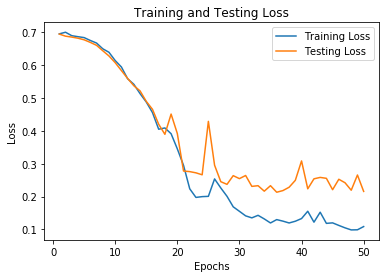

In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

val_Loss = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_Loss, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

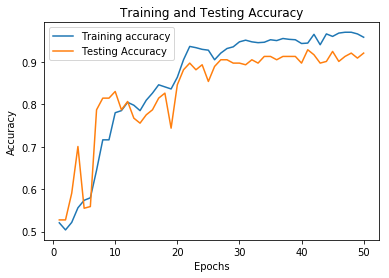

In [211]:
acc = history.history['acc']
val_Acc = history.history['val_acc']
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_Acc, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [235]:
rand = np.random.randint(0, 100)
#PRØV CLEAN_TEXT
test_Cat = cat_Features[rand]
#test_Cat = [i.strip(']./,+_-?:\[') for i in test_Cat]
test_Cat = [x for x in test_Cat.split(' ') if x not in stopwords.words('english')]
test_Cat = str(test_Cat)
processed_Test_Cat = str(test_Cat.strip())[1:-3].replace(' ', ' ')
test_Label = label[rand]
#processed_Test_Cat = remove_Symbols(test_Cat)
test_tokenizer = Tokenizer(num_words=tok_Len)
test_tokenizer.fit_on_texts(processed_Test_Cat)
test_sequences = tokenizer.texts_to_sequences(processed_Test_Cat)
term_Index = test_tokenizer.word_index
test_Cat_Padded = pad_sequences(test_sequences, padding = 'post', maxlen = sen_Len)

In [236]:
prediction = model.predict(test_Cat_Padded)

In [237]:
test_Label

array([0, 1], dtype=uint8)

In [238]:
prediction[rand].argsort()[-len(prediction[rand]):]

array([0, 1], dtype=int64)

In [239]:
test_Cat

"['', 'text', 'Hillary', 'Clinton', 'says', 'guns', 'exceed', 'next', 'nine', 'categories', 'leading', 'cause', 'death', 'young', 'black', 'men', 'https://t.co/lRw9kWS2im', 'via', '@PolitiFact', 'username', 'Lynn', 'Smith', 'Miller', '-', 'name_zero_user_mentions_entities:', 'PolitiFact', '-', 'location_user:', '', '-', 'description_user:', '', '-', 'contributors_enabled_user:', 'False', '-', 'default_profile_image_user:', 'False', '-', 'default_profile_user:', 'True', '-', 'favorited:', 'False', '-', 'follow_request_sent_user:', 'False', '-', 'following_user:', 'False', '-', 'geo_enabled_user:', 'False', '-', 'has_extended_profile_user:', 'False', '-', 'id:', '7.22928950624723e+17', '-', 'id_str:', '7.22928950624723e+17', '-', 'id_str_user:', '4915169428', '-', 'id_str_zero_user_mentions_entities:', '8953122', '-', 'id_user:', '4915169428.0', '-', 'id_zero_user_mentions_entities:', '8953122.0', '-', 'is_quote_status:', 'False', '-', 'is_translation_enabled_user:', 'False', '-', 'is_tr

In [ ]:










input1 = Input(shape=(sen_Len,), name='nlp_input') #TEXT
input2 = Input(shape=(10,), name='meta_input') #NON-TEXT ATTRS
emb = Embedding(output_dim=len(term_Index) + 1, input_dim=emb_Dim, weights = [emb_Mat], 
                input_length=sen_Len, 
                trainable=False, 
                name = ‘embeddings’)))(input1)
input1_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
merged = keras.layers.Concatenate(axis=1)([input1_out, input2])
maxpool = keras.layers.GlobalMaxPool1D()(merged)
dropout1 = keras.layers.Dropout(0.1)(maxpool)
dense1 = keras.layers.Dense(1, activation=keras.activations.relu, use_bias=True)(dropout1)
dropout2 = keras.layers.Dropout(0.1)(dense1)
dense2 = keras.layers.Dense(2, input_dim=2, activation=keras.activations.sigmoid, use_bias=True)(dropout2)
model10 = keras.models.Model(inputs=[input1, input2], output=output)
model10.compile(optimizer=’adam’, loss=’binary_crossentropy’,
metrics = ['accuracy')
history = model0.fit([features_Train, CAT_ATTRS],target_Train, batch_size=16, epochs=100, validation_data=(features_Val, target_Val))                                     
                
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history[‘loss’]
val_Loss = history.history[‘val_Loss’]
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label=’Training loss’)
plt.plot(epochs, val_Loss, label=’Validation loss’)
plt.title(‘Training and validation loss’)
plt.xlabel(‘Epochs’)
plt.ylabel(‘Loss’)
plt.legend()
plt.show();
                
acc = history.history[‘acc’]
val_Acc = history.history[‘val_acc’]
plt.plot(epochs, acc, label=’Training acc’)
plt.plot(epochs, val_Acc, label=’Validation acc’)
plt.title(‘Training and validation accuracy’)
plt.ylabel(‘Accuracy’)
plt.xlabel(‘Epochs’)
plt.legend()
plt.show();

#PRØV CLEAN_TEXT
rand = np.random.randint(0, 100)
test_Cat = cat_Features[rand]
test_Label = target[rand]
test_Cat = [i.strip(']./,+_-?:\[') for i in test_Cat]
test_Cat = [x for x in test_Cat if x not in stopwords.english]
test_Cat = str(test_Cat)
processed_Test_Cat = str(test_Cat.strip())[1:-3].replace(' ', ' ')
#processed_Test_Cat = remove_Symbols(test_Cat)
test_tokenizer = Tokenizer(num_words=tok_Len)
test_tokenizer.fit_on_texts(processed_Test_Cat)
test_sequences = tokenizer.texts_to_sequences(processed_Test_Cat)
term_Index = test_tokenizer.term_Index
test_Cat_Padded = pad_sequences(test_sequences, padding = ‘post’, maxlen = sen_Len)
                
prediction = model.predict(test_Cat_Padded)
                
prediction[rand].argsort()[-len(prediction[rand]):]